In [1]:
import os, re, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm

from bs4 import BeautifulSoup
from readability import Document  # make sure you installed readability-lxml
import textstat
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib

import requests

nltk.download('punkt')

# Define directories
BASE = r"C:\Users\Febin T Nabeel\Downloads\seo-content-detector"
DATA_DIR = os.path.join(BASE, "data")
MODELS_DIR = os.path.join(BASE, "models")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print("✅ Setup complete.")


✅ Setup complete.


[nltk_data] Downloading package punkt to C:\Users\Febin T
[nltk_data]     Nabeel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def clean_spaces(s: str) -> str:
    if not isinstance(s, str): return ""
    return re.sub(r"\s+", " ", s).strip()

def parse_html_to_text(html: str):
    """Safely extract readable text from raw HTML."""
    if not isinstance(html, str) or not html.strip():
        return {"title": "", "body_text": "", "word_count": 0}
    try:
        doc = Document(html)
        title = clean_spaces(doc.short_title() or "")
        soup_main = BeautifulSoup(doc.summary(), "lxml")
        chunks = []
        for sel in ["article", "main", "section", "p"]:
            for tag in soup_main.select(sel):
                txt = tag.get_text(" ", strip=True)
                if txt: chunks.append(txt)
        body = clean_spaces(" ".join(chunks))
        if not body:
            body = clean_spaces(BeautifulSoup(html, "lxml").get_text(" ", strip=True))
        wc = len(body.split())
        return {"title": title, "body_text": body, "word_count": wc}
    except Exception:
        txt = clean_spaces(BeautifulSoup(html or "", "lxml").get_text(" ", strip=True))
        return {"title": "", "body_text": txt, "word_count": len(txt.split())}

def sentence_count(text: str) -> int:
    if not isinstance(text, str) or not text.strip():
        return 0
    return len(nltk.sent_tokenize(text))


In [3]:
data_path = os.path.join(DATA_DIR, "data.csv")
df_raw = pd.read_csv(data_path)

print(f"✅ Loaded dataset: {df_raw.shape[0]} rows")
df_raw.head()


✅ Loaded dataset: 81 rows


,url,html_content
0,https://www.cm-alliance.com/cybersecurity-blog,"<!doctype html><!--[if lt IE 7]> <html class=""..."
1,https://www.varonis.com/blog/cybersecurity-tips,"<!doctype html><html lang=""en""><head>\n <me..."
2,https://www.cisecurity.org/insights/blog/11-cy...,<!DOCTYPE html><html data-unhead-vue-server-re...
3,https://www.cisa.gov/topics/cybersecurity-best...,"\n\n<!DOCTYPE html>\n<html lang=""en"" dir=""ltr""..."
4,https://www.qnbtrust.bank/Resources/Learning-C...,NaN


In [4]:
rows = []
for _, row in tqdm(df_raw.iterrows(), total=len(df_raw)):
    url = row["url"]
    html = row["html_content"]
    parsed = parse_html_to_text(html)
    rows.append({
        "url": url,
        "title": parsed["title"],
        "body_text": parsed["body_text"],
        "word_count": parsed["word_count"]
    })

extracted = pd.DataFrame(rows)
extracted.to_csv(os.path.join(DATA_DIR, "extracted_content.csv"), index=False)
print("✅ Parsed HTML content saved to extracted_content.csv")
extracted.head()


100%|██████████| 81/81 [00:32<00:00,  2.47it/s]

✅ Parsed HTML content saved to extracted_content.csv


,url,title,body_text,word_count
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,"In the modern digital world, financial institu...",1541
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Cybersecurity is gaining more importance globa...,1480
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Cybersecurity is inextricably tied to the tech...,924
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices,Secure .gov websites use HTTPS A lock ( Lock A...,31
4,https://www.qnbtrust.bank/Resources/Learning-C...,,,0


In [5]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to C:\Users\Febin T
[nltk_data]     Nabeel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Febin T
[nltk_data]     Nabeel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
data = extracted.copy()

# Basic features
data["sentence_count"] = data["body_text"].apply(sentence_count)
data["flesch_reading_ease"] = data["body_text"].apply(
    lambda t: textstat.flesch_reading_ease(t) if t.strip() else 0.0
)

# TF-IDF for keywords
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
tfidf_matrix = tfidf.fit_transform(data["body_text"])

def top_k_keywords(row_vec, k=5):
    arr = row_vec.toarray().ravel()
    top = np.argsort(arr)[::-1][:k]
    feats = np.array(tfidf.get_feature_names_out())[top]
    return "|".join(feats)

data["top_keywords"] = [top_k_keywords(tfidf_matrix[i]) for i in range(tfidf_matrix.shape[0])]

# Embeddings (Sentence Transformers)
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedder.encode(data["body_text"].tolist(), normalize_embeddings=True)

data["embedding"] = [json.dumps(e.tolist()) for e in embeddings]
data.to_csv(os.path.join(DATA_DIR, "features.csv"), index=False)

print("✅ Feature extraction complete.")
data.head()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Feature extraction complete.


,url,title,body_text,word_count,sentence_count,flesch_reading_ease,top_keywords,embedding
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,"In the modern digital world, financial institu...",1541,58,49.479880,2025|september|october|cyber|august,"[-0.04403552785515785, -0.017369410023093224, ..."
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Cybersecurity is gaining more importance globa...,1480,73,38.291616,varonis|access|app|security|data,"[-0.027240866795182228, -0.051758620887994766,..."
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Cybersecurity is inextricably tied to the tech...,924,59,53.654331,password|passphrase|authentication|protect|use,"[-0.006452964153140783, -0.007180618122220039,..."
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices,Secure .gov websites use HTTPS A lock ( Lock A...,31,2,55.007155,https|gov|lock|secure|websites,"[-0.031552184373140335, -0.009457170031964779,..."
4,https://www.qnbtrust.bank/Resources/Learning-C...,,,0,0,0.000000,ztna|en|employ|employed|employee,"[-0.11883842945098877, 0.04829865321516991, -0..."


In [7]:
sim = cosine_similarity(embeddings)
threshold = 0.80

pairs = []
urls = data["url"].tolist()
for i in range(len(urls)):
    for j in range(i + 1, len(urls)):
        if sim[i, j] >= threshold:
            pairs.append({"url1": urls[i], "url2": urls[j], "similarity": float(sim[i, j])})

dup_df = pd.DataFrame(pairs)
dup_df.to_csv(os.path.join(DATA_DIR, "duplicates.csv"), index=False)

data["is_thin"] = data["word_count"] < 500

print(f"✅ Total Pages: {len(data)}")
print(f"✅ Duplicate Pairs: {len(dup_df)}")
print(f"✅ Thin Content Pages: {data['is_thin'].sum()} ({100 * data['is_thin'].mean():.1f}%)")

dup_df.head()


✅ Total Pages: 81
✅ Duplicate Pairs: 72
✅ Thin Content Pages: 48 (59.3%)


,url1,url2,similarity
0,https://www.qnbtrust.bank/Resources/Learning-C...,https://www.connectwise.com/blog/phishing-prev...,1.0
1,https://www.qnbtrust.bank/Resources/Learning-C...,https://www.hpe.com/us/en/what-is/sd-wan.html,1.0
2,https://www.qnbtrust.bank/Resources/Learning-C...,https://support.microsoft.com/en-us/windows/ho...,1.0
3,https://www.qnbtrust.bank/Resources/Learning-C...,https://www.cloudflare.com/learning/access-man...,1.0
4,https://www.qnbtrust.bank/Resources/Learning-C...,https://towardsdatascience.com/machine-learnin...,1.0


In [9]:
def quality_label(row):
    wc = row["word_count"]
    rd = row["flesch_reading_ease"]
    if (wc > 1500) and (50 <= rd <= 70):
        return "High"
    if (wc < 500) or (rd < 30):
        return "Low"
    return "Medium"

data["quality_label"] = data.apply(quality_label, axis=1)

X = data[["word_count", "sentence_count", "flesch_reading_ease"]]
y = data["quality_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("=== Model Performance ===")
print(classification_report(y_test, pred))
print("Accuracy:", accuracy_score(y_test, pred))

joblib.dump(model, os.path.join(MODELS_DIR, "quality_model.pkl"))
print("✅ Model saved to models/quality_model.pkl")


=== Model Performance ===
              precision    recall  f1-score   support

        High       1.00      0.50      0.67         2
         Low       0.93      1.00      0.97        14
      Medium       0.89      0.89      0.89         9

    accuracy                           0.92        25
   macro avg       0.94      0.80      0.84        25
weighted avg       0.92      0.92      0.91        25

Accuracy: 0.92
✅ Model saved to models/quality_model.pkl


<Figure size 800x500 with 0 Axes>

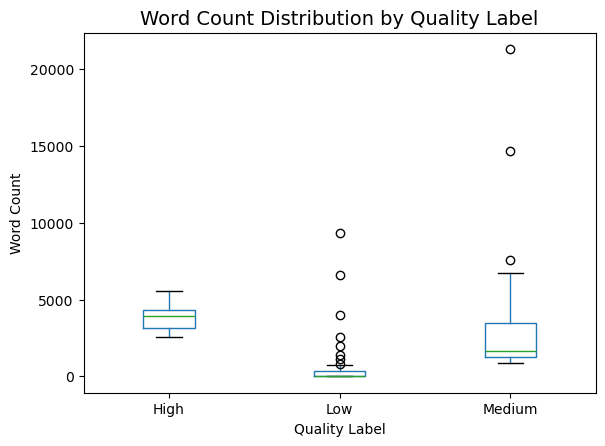

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
data.boxplot(column="word_count", by="quality_label", grid=False)
plt.title("Word Count Distribution by Quality Label", fontsize=14)
plt.suptitle("")
plt.xlabel("Quality Label")
plt.ylabel("Word Count")
plt.show()


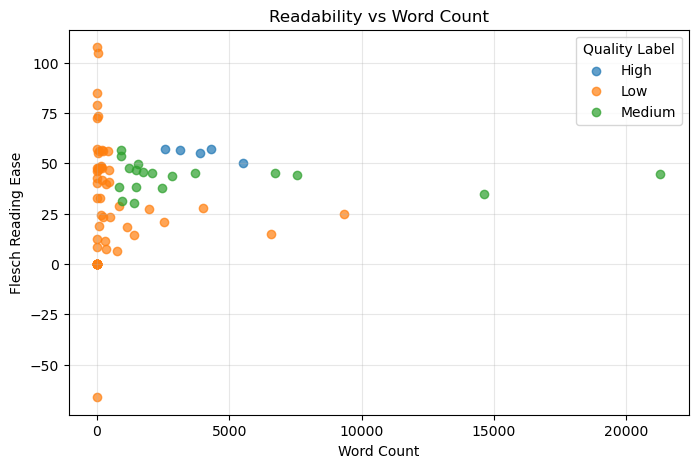

In [11]:
plt.figure(figsize=(8,5))
for label, subset in data.groupby("quality_label"):
    plt.scatter(subset["word_count"], subset["flesch_reading_ease"], label=label, alpha=0.7)

plt.title("Readability vs Word Count")
plt.xlabel("Word Count")
plt.ylabel("Flesch Reading Ease")
plt.legend(title="Quality Label")
plt.grid(True, alpha=0.3)
plt.show()


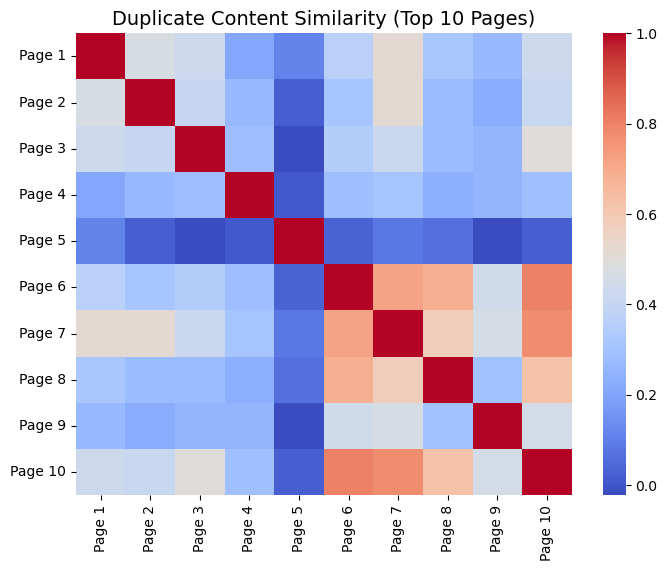

In [12]:
import seaborn as sns

# Limit to top 10 for clarity
subset_size = min(10, len(data))
subset_sim = cosine_similarity(embeddings[:subset_size])
subset_urls = [f"Page {i+1}" for i in range(subset_size)]

plt.figure(figsize=(8,6))
sns.heatmap(subset_sim, xticklabels=subset_urls, yticklabels=subset_urls, cmap="coolwarm", annot=False)
plt.title("Duplicate Content Similarity (Top 10 Pages)", fontsize=14)
plt.show()


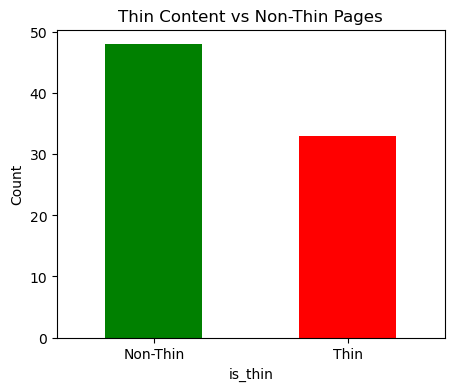

In [13]:
thin_counts = data["is_thin"].value_counts()
thin_counts.plot(kind="bar", color=["green", "red"], figsize=(5,4))
plt.title("Thin Content vs Non-Thin Pages")
plt.xticks([0, 1], ["Non-Thin", "Thin"], rotation=0)
plt.ylabel("Count")
plt.show()


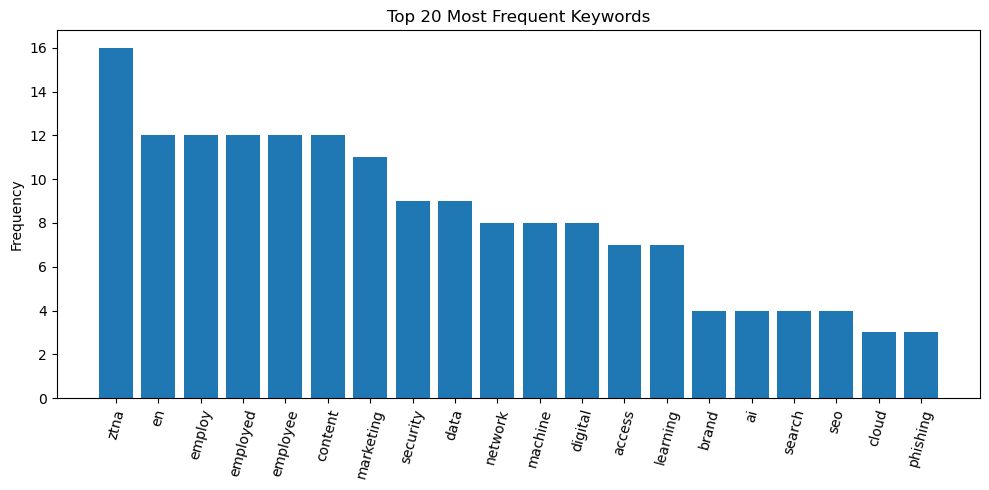

In [14]:
from collections import Counter

# Combine all keywords, split by '|'
all_keywords = "|".join(data["top_keywords"].fillna("")).split("|")
counter = Counter(all_keywords)

top_keywords = dict(counter.most_common(20))

plt.figure(figsize=(10,5))
plt.bar(top_keywords.keys(), top_keywords.values())
plt.title("Top 20 Most Frequent Keywords")
plt.xticks(rotation=75)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [20]:
import requests
from sklearn.metrics.pairwise import cosine_similarity

def fetch_html(url):
    headers = {"User-Agent": "Mozilla/5.0 (compatible; SEO-Detector/1.0)"}
    try:
        r = requests.get(url, headers=headers, timeout=10)
        if r.status_code == 200:
            return r.text
    except:
        return ""
    return ""

def analyze_url(url):
    html = fetch_html(url)
    parsed = parse_html_to_text(html)
    text = parsed["body_text"]

    wc = len(text.split())
    sc = sentence_count(text)
    fr = textstat.flesch_reading_ease(text)
    label = model.predict([[wc, sc, fr]])[0]

    emb = embedder.encode([text], normalize_embeddings=True)
    sims = cosine_similarity(emb, embeddings)[0]
    similar_pages = [
        {"url": data.iloc[i]["url"], "similarity": float(sims[i])}
        for i in np.argsort(sims)[::-1][:5] if sims[i] > 0.6
    ]

    return {
        "url": url,
        "word_count": wc,
        "readability": round(fr, 2),
        "quality_label": label,
        "is_thin": wc < 500,
        "similar_to": similar_pages
    }

# Example usage:
# result = analyze_url("https://www.cisa.gov/topics/cybersecurity-best-practices")
# import json; print(json.dumps(result, indent=2))
